# Required Libraries

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
class UTKDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for file_name in os.listdir(root_dir):
            try:
                age = int(file_name.split("_")[0])
                self.image_paths.append(os.path.join(root_dir, file_name))
                self.labels.append(age)
            except:
                continue

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label

# Tranformations

In [3]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load Dataset

In [ ]:
dataset = UTKDataset(root_dir='D:\\Age_and_gender_detection\\archive\\UTKFace', transform=transform)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Define Model

In [6]:
class AgeDetectionModel(nn.Module):
    def __init__(self):
        super(AgeDetectionModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 1)  
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = AgeDetectionModel()



# Define Loss and Optimizer

In [7]:
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training the Model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


Epoch 1/10, Loss: 249.20416891474346
Epoch 2/10, Loss: 138.01382706820664
Epoch 3/10, Loss: 101.06268734473603
Epoch 4/10, Loss: 87.61733382869933
Epoch 5/10, Loss: 69.11362165222683
Epoch 6/10, Loss: 61.195698852281744
Epoch 7/10, Loss: 49.84798098494994
Epoch 8/10, Loss: 41.19128717580091
Epoch 9/10, Loss: 34.1873030284605
Epoch 10/10, Loss: 28.616251590079038


# Visualize Activation Maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.64].


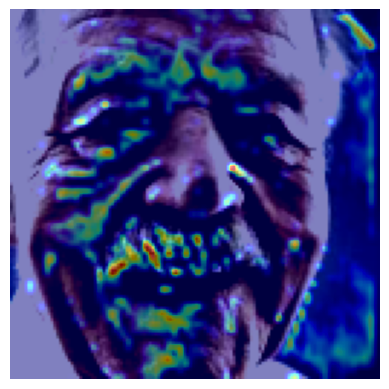

In [9]:
def grad_cam(input_image, model, layer_name):
    model.eval()

    gradients = []
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    def backward_hook_fn(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks
    layer = dict(model.named_modules())[layer_name]
    layer.register_forward_hook(hook_fn)
    layer.register_backward_hook(backward_hook_fn)

    input_image = input_image.unsqueeze(0).to(device)
    output = model(input_image)

    # Get gradient for the most probable output
    output.backward(torch.ones_like(output))

    gradient = gradients[0].cpu().data.numpy()[0]
    activation = activations[0].cpu().data.numpy()[0]

    # Global average pooling on gradients
    weights = np.mean(gradient, axis=(1, 2))
    cam = np.zeros(activation.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * activation[i]

    cam = np.maximum(cam, 0)  # ReLU
    cam = cam / cam.max()  # Normalize

    return cam

# Use Grad-CAM on a sample image
sample_image, _ = dataset[0]
cam = grad_cam(sample_image, model, 'features.4')  # Choose the appropriate layer name

# Plot Grad-CAM overlay
plt.imshow(sample_image.permute(1, 2, 0).numpy())
plt.imshow(cv2.resize(cam, (128, 128)), cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()